In [21]:
!pip install pyspark
!pip install seaborn
!pip install prettytable


Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: Loading egg at c:\program files\python312\lib\site-packages\vboxapi-1.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Task 1 – PySpark
Implementation of Recommendation System

1.

In [2]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.functions import split
from pyspark.sql.functions import count

print(f"Current Working Directory: {os.getcwd()}")

#Create a SparkSession
spark = SparkSession.builder.master("local[*]").appName("ColabPySpark").getOrCreate()

#Load the dataset
relative_path = 'Datasets/Task_1_dataset/ratings.txt'
file_path = os.path.join(os.getcwd(), relative_path)
df = spark.read.text(file_path)

#Rename value as raw_data for clarity
df = df.withColumnRenamed("value", "raw_data")

#Split 'raw_data' into three columns
df = df.select(
    split(col("raw_data"), " ").getItem(0).alias("user_id"),
    split(col("raw_data"), " ").getItem(1).alias("item_id"),
    split(col("raw_data"), " ").getItem(2).alias("rating")
)

#Drop rows with missing values (nulls)
df = df.dropna()

#Gets rid of any outliers or any invalid values
df = df.filter((col("user_id") >= 0) & (col("item_id") >= 0) & (col("rating") <= 4))

#Ensure that the 'rating' is numeric value and within range
df = df.filter((col("rating").cast("float").isNotNull()) & (col("rating").between(0, 4)))

#Show the dataset
df.show(10)

#Checks if there are any duplicates (says true if there is no duplicates)
df.count() == df.dropDuplicates().count()


Current Working Directory: c:\Users\Student\Downloads
+-------+-------+------+
|user_id|item_id|rating|
+-------+-------+------+
|      1|      1|     2|
|      1|      2|     4|
|      1|      3|   3.5|
|      1|      4|     3|
|      1|      5|     4|
|      1|      6|   3.5|
|      1|      7|   3.5|
|      1|      8|     3|
|      1|      9|   2.5|
|      1|     10|     4|
+-------+-------+------+
only showing top 10 rows



False

2.

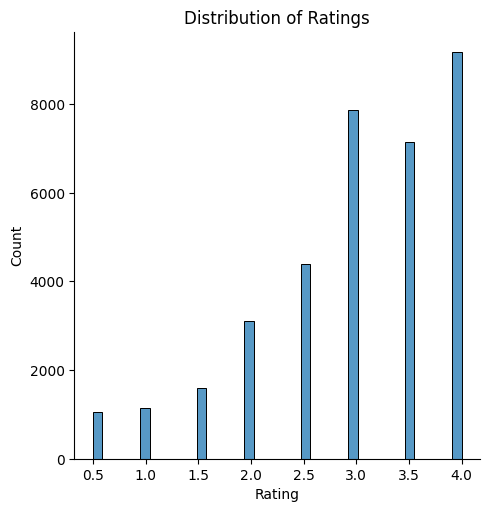

Statistics For Movie Ratings
+----------+------------------+
|Statistics|     Movie Ratings|
+----------+------------------+
|     count|             35497|
|      mean|3.0028030537791928|
|    stddev|0.9186923817926762|
|       min|               0.5|
|       max|               4.0|
+----------+------------------+

Top Rated Movies
+--------+------------------+
|Movie ID|Movie Rating Total|
+--------+------------------+
|       7|              1044|
|      11|               931|
|       2|               915|
|     207|               883|
|       1|               866|
|      17|               815|
|      13|               807|
|     215|               761|
|      12|               756|
|      10|               750|
+--------+------------------+

Lowest Rated Movies
+--------+------------------+
|Movie ID|Movie Rating Total|
+--------+------------------+
|    1361|                 1|
|    1957|                 1|
|    1746|                 1|
|    1512|                 1|
|    1808|    

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

#Casts the rating column as a float so it can be used as a numeric value
#for the next part
df = df.withColumn("rating", col("rating").cast("float"))

#Convert the Spark DataFrame to a Pandas DataFrame for easier plotting
rating_counts_pd = df.toPandas()

#Plot the distribution of ratings Vs their value counts
sns.displot(rating_counts_pd,
            x="rating",
            kde=False)

#The plotting
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.xticks([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0])
# Show the plot
plt.show()

#Analysing the distribution of ratings
print(f"Statistics For Movie Ratings")
stats = df.describe("rating")

#Renaming the columns to make them more readable
stats_renamed = stats.withColumnRenamed("summary", "Statistics") \
                     .withColumnRenamed("rating", "Movie Ratings")

#Show the renamed statistics
stats_renamed.show()

#Top rated and lowest rated shows by users calculated by adding up
 #how many ratings they got
top_rated = (df.groupBy("item_id")
             .agg(F.count("rating").alias("Movie Rating Total"))
             .withColumnRenamed("item_id", "Movie ID")
             .orderBy(F.desc("Movie Rating Total"))
             .limit(10))

low_rated = (df.groupBy("item_id")
             .agg(F.count("rating").alias("Movie Rating Total"))
              .withColumnRenamed("item_id", "Movie ID")
             .orderBy("Movie Rating Total")
             .limit(10))

#Show the results for it
print(f"Top Rated Movies")
top_rated.show()
print(f"Lowest Rated Movies")
low_rated.show()

#Top 10 users who have rated movies the most
print(f"Top Ten Users Who Rate The Most Movies")
top_users = (df.groupBy("user_id")
             .agg(F.count("rating").alias("Total Movie Ratings"))
             .orderBy(F.desc("Total Movie Ratings"))
             .limit(10))
top_users.show()

#Display number of unique users and movies
unique_users = df.select("user_id").distinct().count()
unique_items = df.select("item_id").distinct().count()

#Print it to read the amount of users vs movies there are
print(f"Number of unique users: {unique_users}")
print(f"Number of unique movies: {unique_items}")


3.

Model based reccomender - ALS

In [16]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.feature import StringIndexer
from pyspark.sql import functions as F
from pyspark.ml import Estimator
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

#Indexing as integers
user_indexer = StringIndexer(inputCol="user_id", outputCol="user_index")
item_indexer = StringIndexer(inputCol="item_id", outputCol="item_index")

#Drop any existing 'user_index' and 'item_index' columns if present so the code doesn't error
if "user_index" in df.columns and "item_index" in df.columns:
    df = df.drop("user_index", "item_index")

#StringIndexers
df = user_indexer.fit(df).transform(df)
df = item_indexer.fit(df).transform(df)

#Convert the ratings into floats
df = df.withColumn("rating", df["rating"].cast("float"))

#ALS model
ALSmodel = ALS(
    userCol="user_index",
    itemCol="item_index",
    ratingCol="rating",
    coldStartStrategy="drop",
    implicitPrefs=False,
    rank=10,
    maxIter=10)

#Train the model
model = ALSmodel.fit(df)

#Generate the movie recommendations for all the users
user_recommendations = model.recommendForAllUsers(10)

#Make predictions and display
predictions = model.transform(df)

# Evaluate the model by computing the MAE of the data
evaluator = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction")
MAE = evaluator.evaluate(predictions)
print(MAE)

#Extract recommended movie IDs and the movie predicted ratings
user_recommendations = user_recommendations.select(
    F.col("user_index").alias("User ID"),
    F.col("recommendations").getItem(0).getField("item_index").alias("Movie Recommendation ID"),
    F.col("recommendations").getItem(0).getField("rating").alias("Predicted Rating")
)

#Show the top ten users with their reccomendation for movie
#and their predicted movie rating
user_recommendations.show(10, truncate=False)

0.4325489670526855
+-------+-----------------------+----------------+
|User ID|Movie Recommendation ID|Predicted Rating|
+-------+-----------------------+----------------+
|1      |1809                   |3.8706324       |
|3      |1336                   |4.029119        |
|6      |2030                   |3.8857353       |
|12     |492                    |4.132997        |
|13     |1021                   |5.174495        |
|16     |1021                   |3.9443088       |
|20     |661                    |4.5062304       |
|22     |250                    |4.2408667       |
|26     |1398                   |4.1530027       |
|27     |134                    |4.119683        |
+-------+-----------------------+----------------+
only showing top 10 rows



Task 2 – MapReduce for Margie Travel dataset

1.

In [ ]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
os.environ["PYSPARK_PYTHON"] =
os.environ["PYSPARK_DRIVER_PYTHON"] = 
#Load the flight data CSV as DataFrame
flight_data_df = spark.read.option("header", "false").csv("./Datasets/Task_2_dataset/AComp_Passenger_data_no_error.csv")

sc = SparkContext.getOrCreate()
sc.stop()

#increasing power
conf = SparkConf() \
    .setAppName("FlightDataAnalysis") \
    .setMaster("local[*]") \
    .set("spark.driver.memory","4g") \
    .set("spark.network.timeout","800s") \
    .set("spark.executor.heartbeatInterval","100s") \
    .set("spark.python.worker.reuse","false")

sc = SparkContext(conf=conf)
spark = SparkSession
#Convert it to RDD
flight_data_rdd = flight_data_df.rdd

#Extract the departure airport from the dataset and count the flights
flight_count_rdd = flight_data_rdd.map(lambda row: (row['_c2'], 1))

#Add up the flight counts by departure airport
airport_flight_counts = flight_count_rdd.reduceByKey(lambda x, y: x + y)

# Create an RDD of just departure airports
departure_airports_rdd = airport_flight_counts.map(lambda x: x[0])

#Collect and display the flight counts for each airport
airport_flight_counts_result = airport_flight_counts.collect()

#Find unused airports by subtracting used departure airports from all airports
all_airports_rdd = flight_data_rdd.flatMap(lambda row: [row['_c2'], row['_c3']]).distinct()
unused_airports_rdd = all_airports_rdd.subtract(departure_airports_rdd)

#Collect and display results
unused_airports = unused_airports_rdd.collect()

#Airports not used for departure
print("Airports not used as departure points:")
for airport in unused_airports:
    print(airport)

#Add a space for readability
print()

#Print final count of flights that happened
print("Flight count from each airport:")
for airport, count in sorted(airport_flight_counts_result, key=lambda a: a[1], reverse=True):
    print(f"Airport {airport} has {count} flights.")

Py4JJavaError: An error occurred while calling o1779.javaToPython.
: java.lang.IllegalStateException: Cannot call methods on a stopped SparkContext.
This stopped SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance(Unknown Source)
java.base/jdk.internal.reflect.DelegatingConstructorAccessorImpl.newInstance(Unknown Source)
java.base/java.lang.reflect.Constructor.newInstanceWithCaller(Unknown Source)
java.base/java.lang.reflect.Constructor.newInstance(Unknown Source)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
py4j.ClientServerConnection.run(ClientServerConnection.java:106)
java.base/java.lang.Thread.run(Unknown Source)

The currently active SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance(Unknown Source)
java.base/jdk.internal.reflect.DelegatingConstructorAccessorImpl.newInstance(Unknown Source)
java.base/java.lang.reflect.Constructor.newInstanceWithCaller(Unknown Source)
java.base/java.lang.reflect.Constructor.newInstance(Unknown Source)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
py4j.ClientServerConnection.run(ClientServerConnection.java:106)
java.base/java.lang.Thread.run(Unknown Source)
         
	at org.apache.spark.SparkContext.assertNotStopped(SparkContext.scala:122)
	at org.apache.spark.SparkContext.broadcastInternal(SparkContext.scala:1654)
	at org.apache.spark.SparkContext.broadcast(SparkContext.scala:1639)
	at org.apache.spark.sql.execution.datasources.csv.CSVFileFormat.buildReader(CSVFileFormat.scala:102)
	at org.apache.spark.sql.execution.datasources.FileFormat.buildReaderWithPartitionValues(FileFormat.scala:138)
	at org.apache.spark.sql.execution.datasources.FileFormat.buildReaderWithPartitionValues$(FileFormat.scala:129)
	at org.apache.spark.sql.execution.datasources.TextBasedFileFormat.buildReaderWithPartitionValues(FileFormat.scala:346)
	at org.apache.spark.sql.execution.FileSourceScanExec.inputRDD$lzycompute(DataSourceScanExec.scala:548)
	at org.apache.spark.sql.execution.FileSourceScanExec.inputRDD(DataSourceScanExec.scala:537)
	at org.apache.spark.sql.execution.FileSourceScanExec.doExecute(DataSourceScanExec.scala:575)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:195)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:246)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:243)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:191)
	at org.apache.spark.sql.execution.QueryExecution.toRdd$lzycompute(QueryExecution.scala:207)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:206)
	at org.apache.spark.sql.Dataset.javaToPython(Dataset.scala:4140)
	at jdk.internal.reflect.GeneratedMethodAccessor134.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.base/java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Unknown Source)


2.

In [41]:
from pyspark import SparkContext, SparkConf
from datetime import datetime
from pyspark.sql import SparkSession

#increasing power
conf = SparkConf() \
    .setAppName("FlightDataAnalysis") \
    .setMaster("local[*]") \
    .set("spark.driver.memory","4g") \
    .set("spark.network.timeout","800s") \
    .set("spark.executor.heartbeatInterval","100s") \
    .set("spark.python.worker.reuse","false")

#Load the flight data CSV as RDD
flight_data_rdd = spark.read.option("header", "false").csv("./Datasets/Task_2_dataset/AComp_Passenger_data_no_error.csv").rdd

#Rename columns manually after loading the data
flight_data_rdd = flight_data_rdd.map(lambda row: (
    row[0],  # Passenger_ID
    row[1],  # Flight_ID
    row[2],  # Departure_Airport
    row[3],  # Arrival_Airport
    row[4],  # Dept_Time (timestamp)
))

#Extract Flight_ID and Passenger_ID for counting passengers
flight_passenger_rdd = flight_data_rdd.map(lambda row: (row[1], row[0]))  # (Flight_ID, Passenger_ID)

#Count the number of unique passengers per Flight_ID
flight_passenger_count_rdd = flight_passenger_rdd.distinct().mapValues(lambda x: 1).reduceByKey(lambda a, b: a + b)

#Map flight details for further processing
flight_info_rdd = flight_data_rdd.map(lambda row: (
    row[1],  # Flight_ID
    (row[2],  # Departure_Airport
     row[3],  # Arrival_Airport
     row[4])  # Dept_Time (timestamp)
))

#Group the flight information with passenger count by Flight_ID
joined_rdd = flight_info_rdd.join(flight_passenger_count_rdd)

#Convert Unix timestamp to HH:MM format
def convert_timestamp(dept_time):
  return datetime.utcfromtimestamp(float(dept_time)).strftime('%H:%M')

#Map the final result making sure that there is no duplication in the final output
flight_summary_rdd = joined_rdd.mapValues(lambda value: (
    value[0][0],
    value[0][1],
    convert_timestamp(value[0][2]),
    value[1]
))

#Collect the results from the RDD into a list
flight_summary_list = flight_summary_rdd.map(lambda x: (x[0], x[1])).distinct().collect()

#Print a formatted header
print(f"{'Flight ID':<15} {'Departure Airport':<20} {'Arrival Airport':<20} {'Dept Time':<10} {'Total Passengers':<15}")

#Print each of the flight's details
for row in flight_summary_list:
    flight_id, (departure_airport, arrival_airport, dept_time, total_passengers) = row
    print(f"{flight_id:<15} {departure_airport:<20} {arrival_airport:<20} {dept_time:<10} {total_passengers:<15}")

AttributeError: 'property' object has no attribute 'option'

3.

In [42]:
from pyspark import SparkContext, SparkConf
from datetime import datetime
from prettytable import PrettyTable
from math import radians, sin, cos, sqrt, atan2

#increasing power
conf = SparkConf() \
    .setAppName("FlightDataAnalysis") \
    .setMaster("local[*]") \
    .set("spark.driver.memory","4g") \
    .set("spark.network.timeout","800s") \
    .set("spark.executor.heartbeatInterval","100s") \
    .set("spark.python.worker.reuse","false")

#Load the datasets as RDDs
flight_data_rdd = spark.read.option("header", "false").csv("./Datasets/Task_2_dataset/AComp_Passenger_data_no_error.csv").rdd
airport_data_rdd = spark.read.option("header", "false").csv("./Datasets/Task_2_dataset/Top30_airports_LatLong.csv").rdd

#Parse the flight data
flight_data_rdd = flight_data_rdd.map(lambda row: (
    row[0],  # Passenger_ID
    row[1],  # Flight_ID
    row[2],  # Departure_Airport
    row[3],  # Arrival_Airport
    float(row[4]),  # Dept_Time (timestamp)
    int(row[5])  # Flight_Time (mins)
))

#Parse the airport data
airport_data_rdd = airport_data_rdd.map(lambda row: (
    row[1],  # IATA/FAA Code
    (float(row[2]), float(row[3]))  # Latitude, Longitude
))

airport_dict = dict(airport_data_rdd.collect())

#Function to calculate line-of-sight distance
def calculate_distance(lat1, lon1, lat2, lon2):
    R = 3440.1  # Radius of Earth in nautical miles
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    return R * 2 * atan2(sqrt(a), sqrt(1 - a))

#Uses MapReduce to calculate the distance
flight_distance_rdd = flight_data_rdd.map(lambda row: (
    row[0],
    row[1],
    row[2],
    row[3],
    datetime.utcfromtimestamp(row[4]).strftime('%H:%M'),
    row[5],
    calculate_distance(
        airport_dict[row[2]][0],
        airport_dict[row[2]][1],
        airport_dict[row[3]][0],
        airport_dict[row[3]][1]
    )  # Line-of-sight distance in nautical miles
))

#Calculate total air miles per passenger
passenger_miles_rdd = flight_distance_rdd.map(lambda row: (row[0], row[6]))  # (Passenger_ID, Distance)
passenger_miles_rdd = passenger_miles_rdd.reduceByKey(lambda x, y: x + y)  # Sum distances for each Passenger_ID

#Find the passenger with the highest air miles (fetch top 1)
highest_miles_passenger = passenger_miles_rdd.takeOrdered(1, key=lambda x: -x[1])[0]

#PrettyTable to display only the top passenger
table = PrettyTable()
table.field_names = ["Passenger ID", "Total Air Miles"]

#Add only the top passenger's row
table.add_row([highest_miles_passenger[0], highest_miles_passenger[1]])

#Print the table with the highest air miles passenger
print("Passenger with the Highest Air Miles:")
print(table)

AttributeError: 'property' object has no attribute 'option'